In [1]:
#pip install -q -U "tensorflow-text==2.8.*"

In [2]:
#pip install -q tf-models-official==2.7.0

In [3]:
#!pip install keras tf-models-official pydot graphviz

In [4]:
#pip install pydot

In [5]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [6]:
tf.keras.backend.set_floatx('float16')
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
data_train = pd.read_csv('C:/Users/liber/Desktop/Stats/4o Semestre/Aprendizado de Maquina/Aprendizado-de-M-quina-UFMG/Treino-Tweet.csv', encoding='latin-1')

In [10]:
data_train

,UserName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...
41152,44951,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,Positive
41155,44954,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [11]:
len(data_train.Location.unique())

12221

In [12]:
data_train = data_train.drop(['Location', 'UserName'], axis= 1)

In [13]:
data_train["Sentiment"].replace({"Extremely Negative":"Negative", "Extremely Positive":"Positive"}, inplace=True)

In [14]:
from numpy import int8
data_train = pd.get_dummies(data_train, columns= ["Sentiment"], drop_first= False, dtype=int8)
data_train

,TweetAt,OriginalTweet,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,1,0
1,16-03-2020,advice Talk to your neighbours family to excha...,0,0,1
2,16-03-2020,Coronavirus Australia: Woolworths to give elde...,0,0,1
3,16-03-2020,My food stock is not the only one which is emp...,0,0,1
4,16-03-2020,"Me, ready to go at supermarket during the #COV...",1,0,0
...,...,...,...,...,...
41152,14-04-2020,Airline pilots offering to stock supermarket s...,0,1,0
41153,14-04-2020,Response to complaint not provided citing COVI...,1,0,0
41154,14-04-2020,You know itÃÂs getting tough when @KameronWi...,0,0,1
41155,14-04-2020,Is it wrong that the smell of hand sanitizer i...,0,1,0


In [15]:
data_train['Label'] = data_train[['Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']].values.tolist()

In [16]:
data_train = data_train.drop(['Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive'], axis= 1)

In [17]:
data_train['TweetAt'] = pd.to_datetime(data_train['TweetAt'])

C:\Users\liber\AppData\Local\Temp\ipykernel_15256\1869342141.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_train['TweetAt'] = pd.to_datetime(data_train['TweetAt'])


In [18]:
data_train.sort_values(by='TweetAt')

,TweetAt,OriginalTweet,Label
25915,2020-01-04,A big kudos to for arresting a man for thousan...,"[0, 1, 0]"
25916,2020-01-04,"#Covid_19: Hunger dey everywhere! Abeg, Bring ...","[1, 0, 0]"
25917,2020-01-04,Food banks are facing a dramatic increase in d...,"[0, 0, 1]"
25918,2020-01-04,Cautiously optimistic Chinese consumer behavio...,"[0, 0, 1]"
25919,2020-01-04,Post #Coronavirus Data\r\r\n1.) #ISM #Manufact...,"[0, 1, 0]"
...,...,...,...
39212,2020-12-04,I donÃÂt think my kid is going to be too ple...,"[0, 0, 1]"
39211,2020-12-04,MKTG expert Kate Muhl chats with about consume...,"[0, 1, 0]"
39210,2020-12-04,Today they had street signs on the floor of th...,"[1, 0, 0]"
39220,2020-12-04,I launched online networking with @Collabor8UK...,"[0, 0, 1]"


In [19]:
data_train["Offset"] = pd.to_datetime('2020-01-04')

In [20]:
data_train["Delta"] = (data_train["TweetAt"] - data_train["Offset"]).dt.days

In [21]:
data_train = data_train.drop(['TweetAt', 'Offset'], axis= 1)

In [22]:
data_train.sort_values(by='Delta')

,OriginalTweet,Label,Delta
25915,A big kudos to for arresting a man for thousan...,"[0, 1, 0]",0
25916,"#Covid_19: Hunger dey everywhere! Abeg, Bring ...","[1, 0, 0]",0
25917,Food banks are facing a dramatic increase in d...,"[0, 0, 1]",0
25918,Cautiously optimistic Chinese consumer behavio...,"[0, 0, 1]",0
25919,Post #Coronavirus Data\r\r\n1.) #ISM #Manufact...,"[0, 1, 0]",0
...,...,...,...
39212,I donÃÂt think my kid is going to be too ple...,"[0, 0, 1]",335
39211,MKTG expert Kate Muhl chats with about consume...,"[0, 1, 0]",335
39210,Today they had street signs on the floor of th...,"[1, 0, 0]",335
39220,I launched online networking with @Collabor8UK...,"[0, 0, 1]",335


In [23]:
data_train["Delta"] = data_train["Delta"].div(335)

In [24]:
data_train.sort_values(by='Delta')

,OriginalTweet,Label,Delta
25915,A big kudos to for arresting a man for thousan...,"[0, 1, 0]",0.0
25916,"#Covid_19: Hunger dey everywhere! Abeg, Bring ...","[1, 0, 0]",0.0
25917,Food banks are facing a dramatic increase in d...,"[0, 0, 1]",0.0
25918,Cautiously optimistic Chinese consumer behavio...,"[0, 0, 1]",0.0
25919,Post #Coronavirus Data\r\r\n1.) #ISM #Manufact...,"[0, 1, 0]",0.0
...,...,...,...
39212,I donÃÂt think my kid is going to be too ple...,"[0, 0, 1]",1.0
39211,MKTG expert Kate Muhl chats with about consume...,"[0, 1, 0]",1.0
39210,Today they had street signs on the floor of th...,"[1, 0, 0]",1.0
39220,I launched online networking with @Collabor8UK...,"[0, 0, 1]",1.0


In [25]:
#inputA = tf.keras.Input(shape=(1,), dtype=float)
#inputB = tf.keras.Input(shape=(), dtype=tf.string)

In [26]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [27]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [28]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [29]:
train, validation = train_test_split(data_train, test_size=0.15)
Tweets = train.OriginalTweet

In [30]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets_encoded = tf.ragged.constant([
    encode_names(n) for n in Tweets])

In [31]:
print('Tokenized Tweets shape', tweets_encoded.shape.as_list())

Tokenized Tweets shape [34983, None]


In [32]:
tweets_encoded[0]

<tf.Tensor: shape=(77,), dtype=int32, numpy=
array([ 12489,  10149,  13028,  27874,    136,  22034,    137,    155,
        46071,  10731,  14212,  10174,    112,    187,  76557,  10107,
        10108,  37110,  21493, 101003,  16868,  21559,  10142,  10105,
        16567,    118,  29682,  21408,    136,  11406,    137,  30786,
        14120,    131,    120,    120,    188,    119,  11170,    120,
          126,  11537,  10929,  53244,  83821,  21793,  12674,    108,
        31206,  37715,  10251,    108,  16567,  10451,  91823,  10336,
          108,  13961,  61883,  14120,    131,    120,    120,    188,
          119,  11170,    120,    194,  12022,  11447,  14703,  10123,
        14703,  10240,  10731,  12177,    102])>

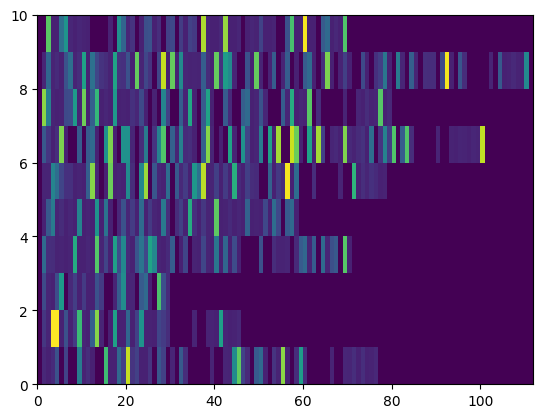

In [33]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets_encoded.shape[0]
input_word_ids = tf.concat([cls, tweets_encoded], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

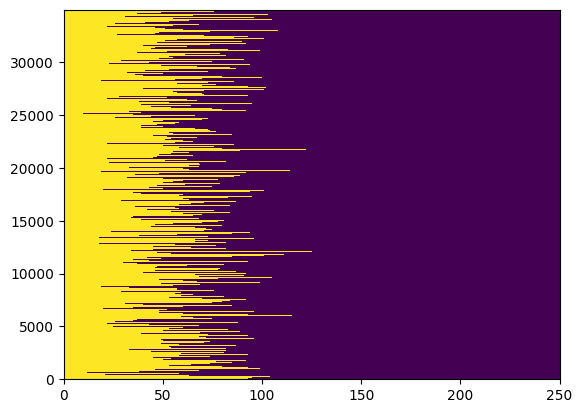

In [34]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

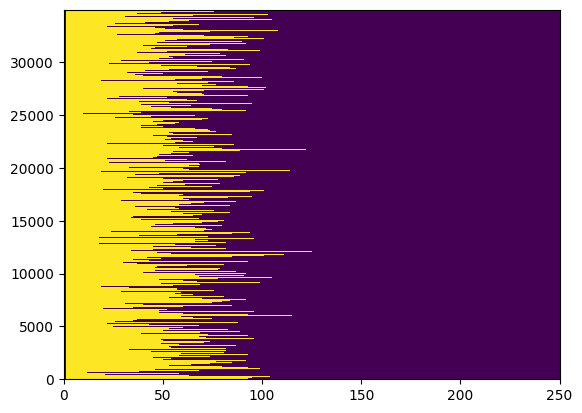

In [35]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets_encoded)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [36]:
#lens = [len(i) for i in input_word_ids]
#max_seq_length = max(lens)
#print('Max length is:', max_seq_length)

In [37]:
max_seq_length = 275
print('Max length is:', max_seq_length)

Max length is: 275


In [38]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, time, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  feature = tf.ragged.constant(time)

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids, 
      'additional_feature': feature}

  return inputs

In [39]:
from numpy import float16
time_train = np.array(train.Delta, dtype=float16) 
time_val = np.array(validation.Delta, dtype=float16) 
X_train = bert_encode(Tweets, tokenizer, time_train, max_seq_length)
labels_train = np.array([np.array(i) for i in train.Label])
X_val = bert_encode(validation.OriginalTweet, tokenizer, time_val, max_seq_length)
labels_val = np.array([np.array(i) for i in validation.Label])

In [40]:
from tensorflow.keras import regularizers

num_class = 3  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
feature_input = tf.keras.layers.Input(shape=(1,),  # [NEW]
                                      dtype=tf.float16, 
                                      name="additional_feature")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])    

output = tf.keras.layers.concatenate([pooled_output, feature_input], name='pooled_with_additional')  # [NEW]

output = tf.keras.layers.Dense(256, activation='relu', name='combined_reg_1', dtype=tf.float32)(output)

output = tf.keras.layers.Dense(128, activation='relu', name='combined_reg_2', dtype=tf.float32)(output)

output = tf.keras.layers.Dropout(rate=0.1)(output)  # [NEW]

  # additional dense layer here

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output', dtype=tf.float32)(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids,
        'additional_feature': feature_input  # [NEW]
        },
        outputs=output)

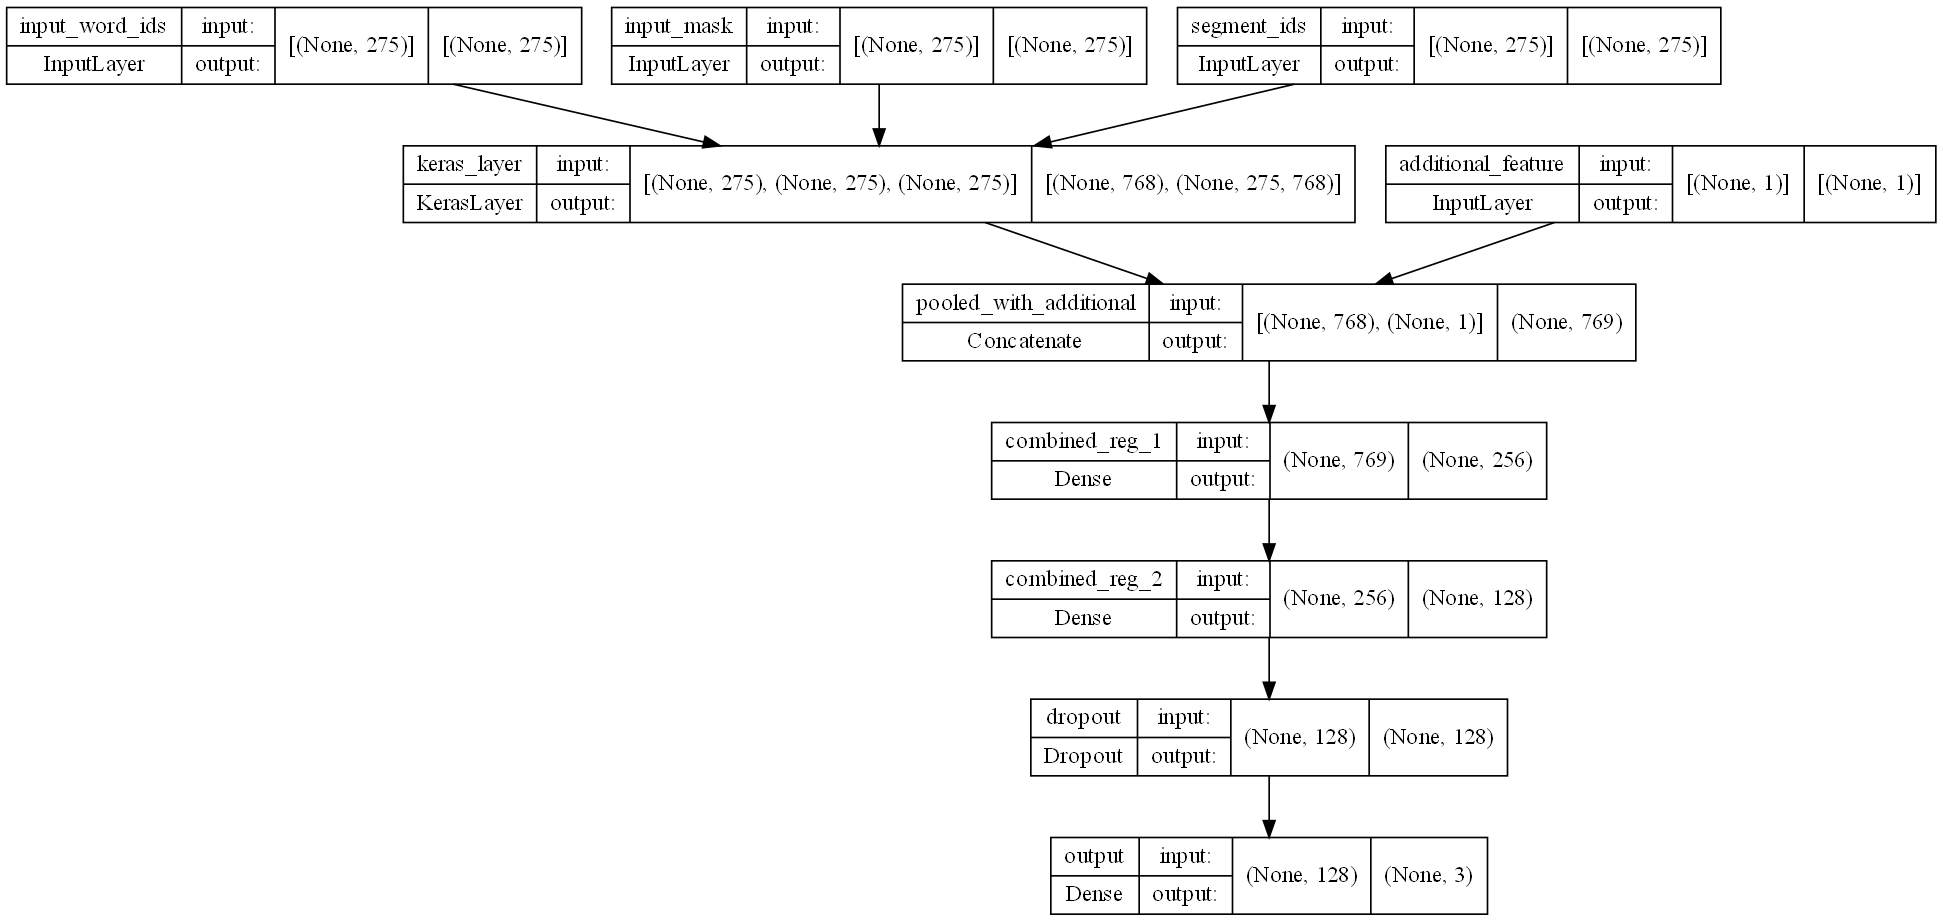

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=120)

In [42]:
epochs = 4
batch_size = 8  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(labels_train)
steps_per_epoch = int(train_data_size / batch_size) 
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [43]:
#pip install tensorflow_addons

In [44]:
import tensorflow_addons as tfa
model.compile(optimizer=optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=3), tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)])

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 275)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 275)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 275, 768)]                'input_mask[0][0]',         

In [46]:
history = model.fit(
    x=X_train,
    y=labels_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=None,
    validation_data=(X_val, labels_val),
    shuffle=True,
    class_weight=None,
    sample_weight=None
)

Epoch 1/4


C:\Users\liber\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("mul_2:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


4373/4373 [==============================] - 857s 193ms/step - loss: 0.6090 - categorical_accuracy: 0.7492 - f1_score: 0.7344 - Multilabel_confusion_matrix: 8745.7500 - val_loss: 0.3724 - val_categorical_accuracy: 0.8724 - val_f1_score: 0.8627 - val_Multilabel_confusion_matrix: 1543.5000
Epoch 2/4
4373/4373 [==============================] - 844s 193ms/step - loss: 0.3127 - categorical_accuracy: 0.8918 - f1_score: 0.8853 - Multilabel_confusion_matrix: 8745.7500 - val_loss: 0.3023 - val_categorical_accuracy: 0.8912 - val_f1_score: 0.8830 - val_Multilabel_confusion_matrix: 1543.5000
Epoch 3/4
4373/4373 [==============================] - 810s 185ms/step - loss: 0.1980 - categorical_accuracy: 0.9339 - f1_score: 0.9278 - Multilabel_confusion_matrix: 8745.7500 - val_loss: 0.2667 - val_categorical_accuracy: 0.9127 - val_f1_score: 0.9038 - val_Multilabel_confusion_matrix: 1543.5000
Epoch 4/4
4373/4373 [==============================] - 807s 184ms/step - loss: 0.1224 - categorical_accuracy: 0.9

In [48]:
data_test = pd.read_csv('C:/Users/liber/Desktop/Stats/4o Semestre/Aprendizado de Maquina/Aprendizado-de-M-quina-UFMG/Teste-Tweet.csv', encoding='latin-1')

from numpy import int8, float16
Tweets_test = data_test.OriginalTweet
data_test['TweetAt'] = pd.to_datetime(data_test['TweetAt'])
data_test["Offset"] = pd.to_datetime('2020-01-04')
data_test["Delta"] = (data_test["TweetAt"] - data_test["Offset"]).dt.days
data_test["Delta"] = data_test["Delta"].div(335)
Time_test = np.array(data_test.Delta, dtype=float16)
X_test = bert_encode(Tweets_test, tokenizer,Time_test, max_seq_length)
 

C:\Users\liber\AppData\Local\Temp\ipykernel_15256\1622576737.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_test['TweetAt'] = pd.to_datetime(data_test['TweetAt'])


In [49]:
data_test

,UserName,Location,TweetAt,OriginalTweet,Offset,Delta
0,1,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,2020-01-04,0.089552
1,2,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,2020-01-04,0.089552
2,3,NaN,2020-02-03,Find out how you can protect yourself and love...,2020-01-04,0.089552
3,4,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,2020-01-04,0.089552
4,5,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,2020-01-04,0.176119
...,...,...,...,...,...,...
3793,3794,Israel ??,2020-03-16,Meanwhile In A Supermarket in Israel -- People...,2020-01-04,0.214925
3794,3795,"Farmington, NM",2020-03-16,Did you panic buy a lot of non-perishable item...,2020-01-04,0.214925
3795,3796,"Haverford, PA",2020-03-16,Asst Prof of Economics @cconces was on @NBCPhi...,2020-01-04,0.214925
3796,3797,NaN,2020-03-16,Gov need to do somethings instead of biar je r...,2020-01-04,0.214925


In [50]:
data_test.sort_values(by='Delta')

,UserName,Location,TweetAt,OriginalTweet,Offset,Delta
0,1,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,2020-01-04,0.089552
1,2,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,2020-01-04,0.089552
2,3,NaN,2020-02-03,Find out how you can protect yourself and love...,2020-01-04,0.089552
3,4,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,2020-01-04,0.089552
4,5,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,2020-01-04,0.176119
...,...,...,...,...,...,...
637,638,"London, England",2020-12-03,@EU_Consumer @EurostarUK @Eurostar @WHO @EU_Co...,2020-01-04,0.997015
636,637,"New York City, New York",2020-12-03,Unusually long lines in my neighborhood superm...,2020-01-04,0.997015
635,636,United States,2020-12-03,We have to take care of each other. If you are...,2020-01-04,0.997015
647,648,Connecticut,2020-12-03,Genuinely concerned about fellow retail worker...,2020-01-04,0.997015


In [51]:
Predictions = model.predict(X_test, verbose=1)
Predictions

119/119 [==============================] - 23s 187ms/step


array([[9.9967980e-01, 1.5016361e-04, 1.7011368e-04],
       [1.8179173e-03, 3.4888603e-03, 9.9469322e-01],
       [1.6993169e-04, 9.0647256e-05, 9.9973947e-01],
       ...,
       [1.2187195e-02, 1.2829997e-01, 8.5951281e-01],
       [9.9963748e-01, 1.6334769e-04, 1.9914546e-04],
       [1.5101445e-04, 8.5720858e-05, 9.9976331e-01]], dtype=float32)

In [52]:
Resultados = []
for i in Predictions:
    if np.argmax(i) == 0:
        Resultados.append("Negative")
    elif np.argmax(i) == 1:
        Resultados.append("Neutral")
    elif np.argmax(i) == 2:
        Resultados.append("Positive")
    else: 
        print(i)

In [53]:
data_test["Sentiment"] = Resultados

In [54]:
data_test.drop(["Offset", "Delta"], axis=1)

,UserName,Location,TweetAt,OriginalTweet,Sentiment
0,1,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,Negative
1,2,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,NaN,2020-02-03,Find out how you can protect yourself and love...,Positive
3,4,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...
3793,3794,Israel ??,2020-03-16,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,"Farmington, NM",2020-03-16,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,"Haverford, PA",2020-03-16,Asst Prof of Economics @cconces was on @NBCPhi...,Positive
3796,3797,NaN,2020-03-16,Gov need to do somethings instead of biar je r...,Negative


In [55]:
data_test.to_csv(r'C:\Users\liber\Desktop\Stats\4o Semestre\Aprendizado de Maquina\Aprendizado-de-M-quina-UFMG\TweetRespostas_FINALv2.csv')